# Cryptocurrency Price Prediction with LSTM - Multi-Step Forecasting

This notebook trains an LSTM model to predict the next 10 cryptocurrency price candles using the processed data with technical indicators.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load and Prepare Data

In [2]:
# Load the processed data
# Replace with your actual file path
processed_data_file = "processed_btc1.csv"
df = pd.read_csv(processed_data_file)

# Convert 'Open Time' to datetime
df['Open Time'] = pd.to_datetime(df['Open Time'])

# Display the first few rows
print("Data shape:", df.shape)
df.head()

Data shape: (40321, 10)


,Open Time,Close,Volume,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,rsi,macd,macd_signal,upper_band,lower_band
0,2025-02-20 00:00:00,96600.02,5.73579,1.34124,129615.036984,41.052032,-22.027333,-20.362096,96671.839716,96454.866284
1,2025-02-20 00:01:00,96675.65,5.92210,3.89078,375961.068791,41.052032,-22.027333,-20.362096,96671.839716,96454.866284
2,2025-02-20 00:02:00,96600.01,6.15018,1.09753,106083.214470,41.052032,-22.027333,-20.362096,96671.839716,96454.866284
3,2025-02-20 00:03:00,96634.42,5.44832,4.29826,415243.350417,41.052032,-22.027333,-20.362096,96671.839716,96454.866284
4,2025-02-20 00:04:00,96662.89,11.75387,9.62415,930328.082841,41.052032,-22.027333,-20.362096,96671.839716,96454.866284


### 2.1. Check for missing values

In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Fill any remaining missing values
df = df.ffill().bfill()

Missing values per column:
Open Time                       0
Close                           0
Volume                          0
Taker Buy Base Asset Volume     0
Taker Buy Quote Asset Volume    0
rsi                             0
macd                            0
macd_signal                     0
upper_band                      0
lower_band                      0
dtype: int64


### 2.2. Feature Selection and Scaling

In [5]:
# Select features for model training (exclude 'Open Time' as it's not a numeric feature)
feature_columns = ['Close', 'Volume', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume',
                    'rsi', 'macd', 'macd_signal', 'upper_band', 'lower_band']
df_features = df[feature_columns]

# Scale the features to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df_features)

# Create a separate scaler for the target variable ('Close') for later inverse scaling
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(df[['Close']])

MinMaxScaler()

### 2.3. Create Time Series Dataset for Multi-Step Forecasting

In [6]:
def create_sequences(data, seq_length, forecast_horizon=10):
    """
    Create sequences of data for multi-step time series prediction
    
    Args:
        data: Scaled feature data
        seq_length: Number of time steps to look back
        forecast_horizon: Number of future time steps to predict
        
    Returns:
        X: Input sequences (features)
        y: Target values (next n closing prices)
    """
    X, y = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        # Feature sequences (all features)
        X.append(data[i:i+seq_length])
        # Targets are the next 'forecast_horizon' closing prices
        # We only take the first column (Close price) for targets
        y.append(data[i+seq_length:i+seq_length+forecast_horizon, 0])
    
    return np.array(X), np.array(y)

In [7]:
# Define sequence length (lookback period) and forecast horizon
sequence_length = 60  # Look back 60 time steps
forecast_horizon = 10  # Predict next 10 candles

# Create sequences
X, y = create_sequences(scaled_features, sequence_length, forecast_horizon)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (40252, 60, 9), y shape: (40252, 10)


### 2.4. Train-Test Split

In [8]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (32201, 60, 9), (32201, 10)
Testing data shape: (8051, 60, 9), (8051, 10)


## 3. Build LSTM Model for Multi-Step Forecasting

In [9]:
def build_lstm_model(input_shape, output_size):
    """
    Build an LSTM model for multi-step time series prediction
    
    Args:
        input_shape: Shape of input data (sequence_length, num_features)
        output_size: Number of future time steps to predict
        
    Returns:
        Compiled Keras model
    """
    model = Sequential()
    
    # First LSTM layer with return sequences for stacking
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Third LSTM layer
    model.add(LSTM(units=64))
    model.add(Dropout(0.2))
    
    # Output layer with forecast_horizon units to predict multiple steps
    model.add(Dense(units=output_size))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [10]:
# Get input shape from training data
input_shape = (X_train.shape[1], X_train.shape[2])
output_size = forecast_horizon  # Number of future values to predict

# Build the model
model = build_lstm_model(input_shape, output_size)

# Display model summary
model.summary()

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,642 (334.54 KB)

 Trainable params: 85,642 (334.54 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the Model

In [11]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model_multi_step.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=160,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - loss: 0.0620 - val_loss: 5.1418e-04
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - loss: 0.0067 - val_loss: 2.6411e-04
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - loss: 0.0048 - val_loss: 5.9504e-04
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - loss: 0.0038 - val_loss: 1.5461e-04
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - loss: 0.0030 - val_loss: 1.4357e-04
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - loss: 0.0025 - val_loss: 2.0863e-04
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 126ms/step - loss: 0.0024 - val_loss: 1.3908e-04
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - loss: 0.0020 - val_loss: 1.6728e-04
Epoch 9/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - loss: 0.0017 - val_loss: 1.3269e-04
Epoch 10/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - loss: 0.0016 - val_loss: 1.5351e-04
Epoch 11/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - loss: 0.001

### 4.1. Plot Training History

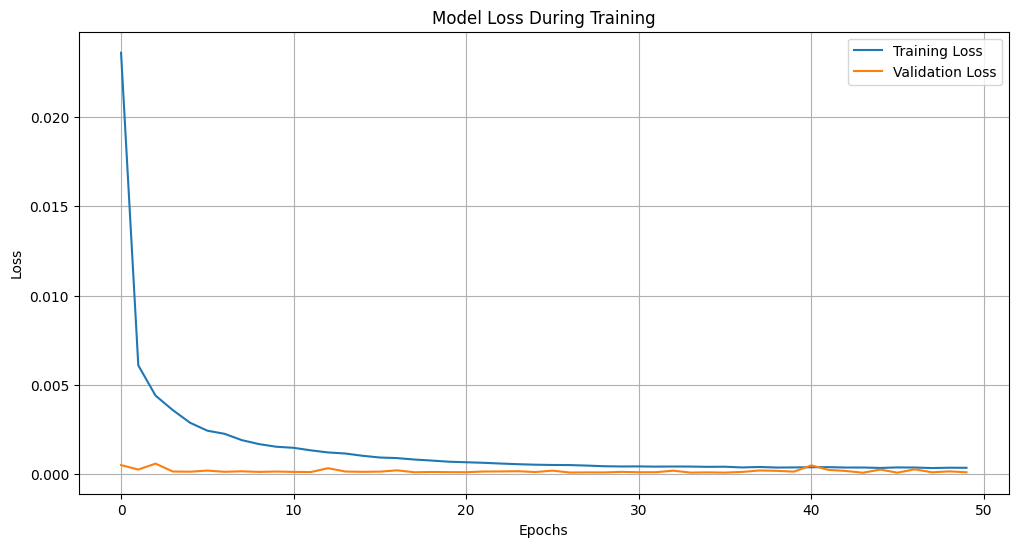

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. Evaluate the Model

In [13]:
# Make predictions on the test set
predicted_scaled = model.predict(X_test)

# Initialize arrays to store inverse-transformed values
predicted_prices = np.zeros((predicted_scaled.shape[0], predicted_scaled.shape[1]))
actual_prices = np.zeros((y_test.shape[0], y_test.shape[1]))

# Inverse transform each step in the forecast horizon
for i in range(forecast_horizon):
    # Extract the i-th step predictions and actual values
    pred_step = predicted_scaled[:, i].reshape(-1, 1)
    actual_step = y_test[:, i].reshape(-1, 1)
    
    # Inverse transform to original scale
    predicted_prices[:, i] = close_scaler.inverse_transform(pred_step).flatten()
    actual_prices[:, i] = close_scaler.inverse_transform(actual_step).flatten()

252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


In [14]:
# Calculate performance metrics for each forecast step
for step in range(forecast_horizon):
    mse = mean_squared_error(actual_prices[:, step], predicted_prices[:, step])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_prices[:, step], predicted_prices[:, step])
    r2 = r2_score(actual_prices[:, step], predicted_prices[:, step])
    
    print(f"Step {step+1} (t+{step+1})")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.4f}")
    print("---")

# Calculate overall metrics across all steps
overall_mse = mean_squared_error(actual_prices.flatten(), predicted_prices.flatten())
overall_rmse = np.sqrt(overall_mse)
overall_mae = mean_absolute_error(actual_prices.flatten(), predicted_prices.flatten())
overall_r2 = r2_score(actual_prices.flatten(), predicted_prices.flatten())

print("Overall Performance:")
print(f"  MSE: {overall_mse:.2f}")
print(f"  RMSE: {overall_rmse:.2f}")
print(f"  MAE: {overall_mae:.2f}")
print(f"  R²: {overall_r2:.4f}")

Step 1 (t+1)
  MSE: 8614.42
  RMSE: 92.81
  MAE: 71.29
  R²: 0.9889
---
Step 2 (t+2)
  MSE: 11765.71
  RMSE: 108.47
  MAE: 83.35
  R²: 0.9848
---
Step 3 (t+3)
  MSE: 12686.84
  RMSE: 112.64
  MAE: 85.13
  R²: 0.9837
---
Step 4 (t+4)
  MSE: 15468.06
  RMSE: 124.37
  MAE: 93.68
  R²: 0.9801
---
Step 5 (t+5)
  MSE: 19490.97
  RMSE: 139.61
  MAE: 106.05
  R²: 0.9750
---
Step 6 (t+6)
  MSE: 21495.34
  RMSE: 146.61
  MAE: 110.50
  R²: 0.9724
---
Step 7 (t+7)
  MSE: 24226.87
  RMSE: 155.65
  MAE: 117.51
  R²: 0.9690
---
Step 8 (t+8)
  MSE: 27363.32
  RMSE: 165.42
  MAE: 125.27
  R²: 0.9650
---
Step 9 (t+9)
  MSE: 29783.29
  RMSE: 172.58
  MAE: 130.69
  R²: 0.9620
---
Step 10 (t+10)
  MSE: 30661.40
  RMSE: 175.10
  MAE: 131.40
  R²: 0.9609
---
Overall Performance:
  MSE: 20155.62
  RMSE: 141.97
  MAE: 105.49
  R²: 0.9741


### 5.1. Visualize Multi-Step Predictions

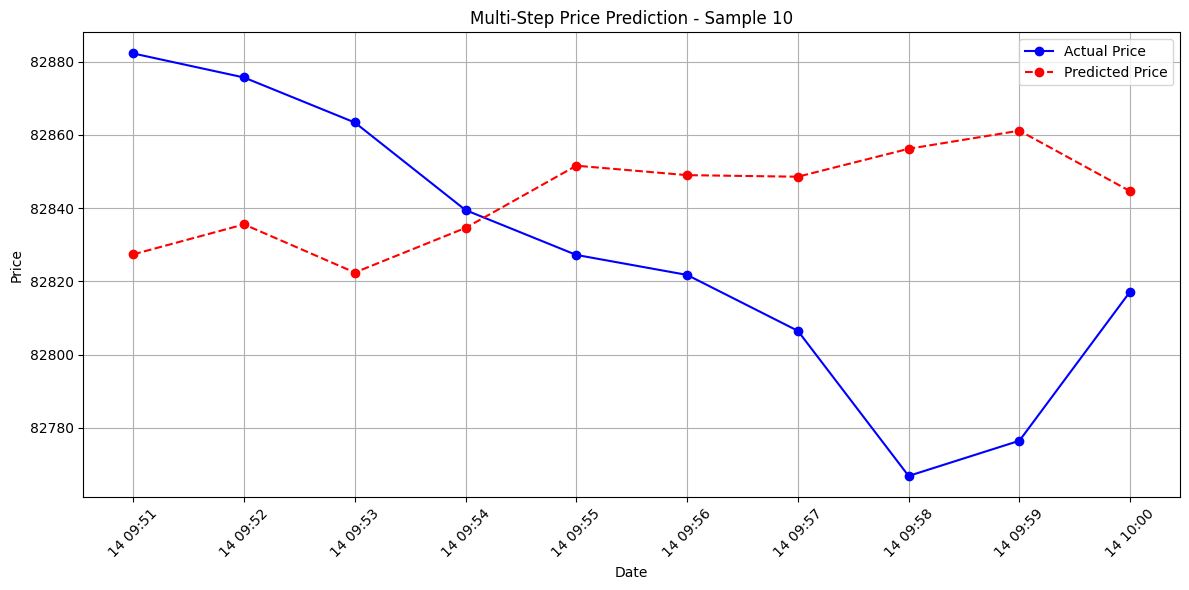

In [19]:
# Select a sample from the test set to visualize
sample_idx = 10  # You can change this to visualize different samples

# Create a time index for the selected sample
test_start_idx = train_size + sequence_length
sample_dates = df['Open Time'][test_start_idx + sample_idx:test_start_idx + sample_idx + forecast_horizon]

# Get the actual and predicted values for this sample
sample_actual = actual_prices[sample_idx]
sample_predicted = predicted_prices[sample_idx]

# Create DataFrame for plotting
results_df = pd.DataFrame({
    'Date': sample_dates,
    'Actual': sample_actual,
    'Predicted': sample_predicted
})

# Plot actual vs predicted prices for this sample
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual'], 'o-', label='Actual Price', color='blue')
plt.plot(results_df['Date'], results_df['Predicted'], 'o--', label='Predicted Price', color='red')
plt.title(f'Multi-Step Price Prediction - Sample {sample_idx}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

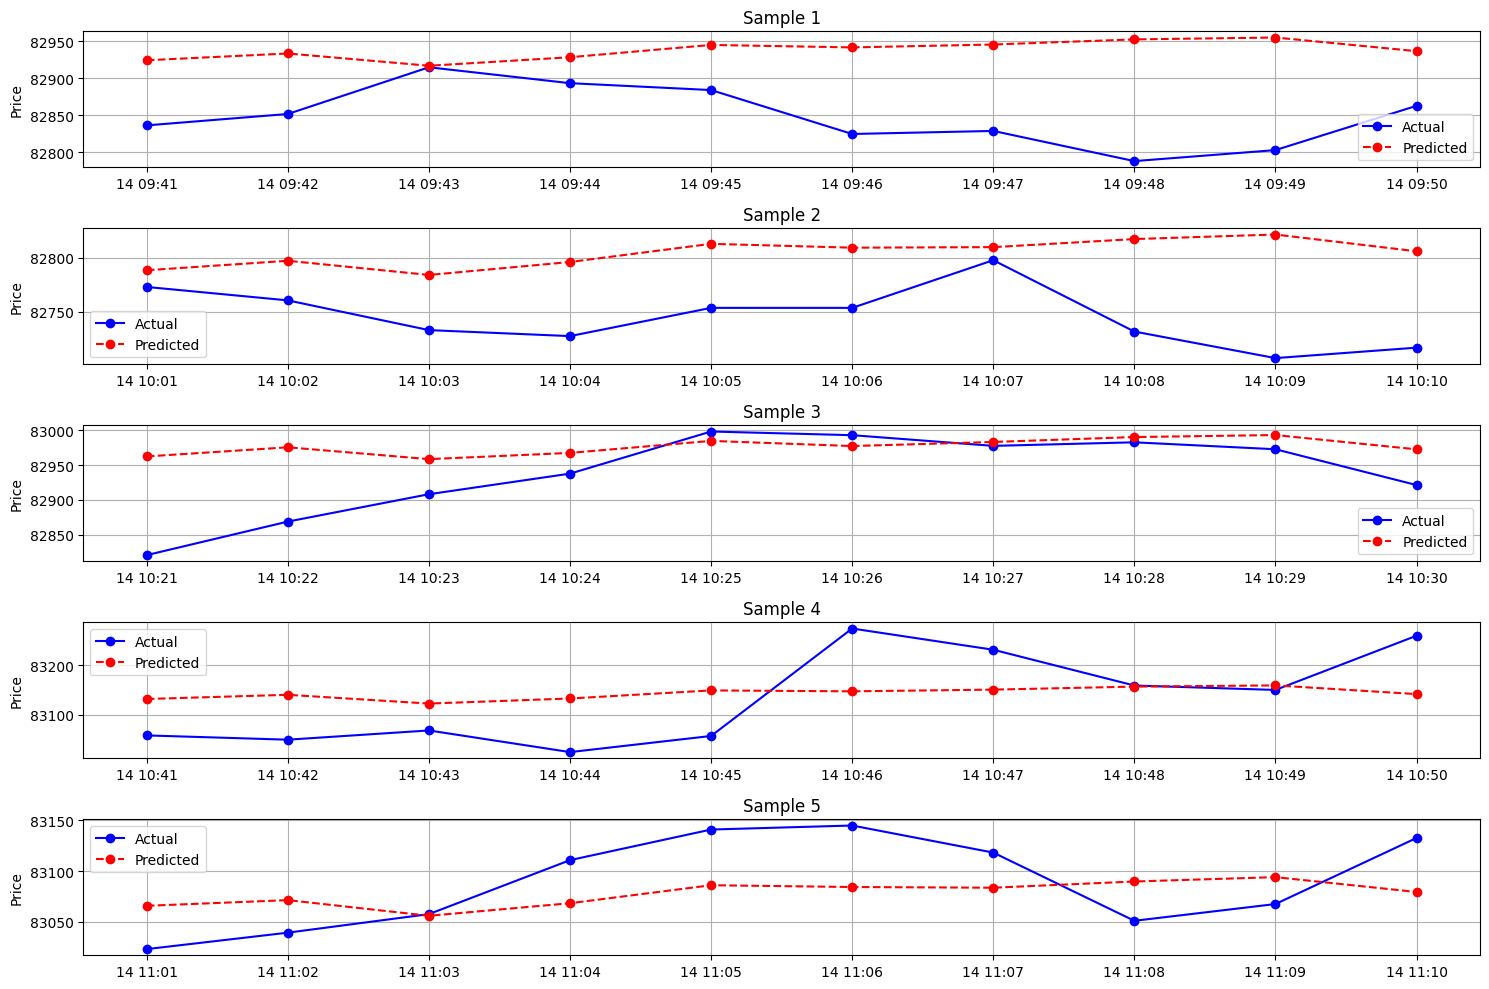

In [20]:
# Visualize multiple samples
num_samples = 5  # Number of samples to visualize
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    sample_idx = i * 20  # Space out the samples
    if sample_idx >= len(actual_prices):
        break
        
    # Get dates for this sample
    sample_dates = df['Open Time'][test_start_idx + sample_idx:test_start_idx + sample_idx + forecast_horizon]
    
    # Get actual and predicted values
    sample_actual = actual_prices[sample_idx]
    sample_predicted = predicted_prices[sample_idx]
    
    # Plot
    plt.subplot(num_samples, 1, i+1)
    plt.plot(sample_dates, sample_actual, 'o-', label='Actual', color='blue')
    plt.plot(sample_dates, sample_predicted, 'o--', label='Predicted', color='red')
    plt.title(f'Sample {i+1}')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    
plt.tight_layout()
plt.show()

## 6. Future Price Prediction (Next 10 Candles)

In [21]:
def predict_next_prices(model, data, sequence_length, forecast_horizon, feature_scaler, close_scaler):
    """
    Predict the next n closing prices
    
    Args:
        model: Trained LSTM model
        data: Full dataset
        sequence_length: Number of time steps to look back
        forecast_horizon: Number of future steps to predict
        feature_scaler: Scaler used for features
        close_scaler: Scaler used for the target variable
        
    Returns:
        next_prices: Predicted next closing prices
    """
    # Get the most recent sequence of data
    last_sequence = data[-sequence_length:]
    
    # Scale the sequence
    last_sequence_scaled = feature_scaler.transform(last_sequence)
    
    # Reshape for LSTM input [samples, time steps, features]
    X_new = np.array([last_sequence_scaled])
    
    # Make prediction
    predicted_scaled = model.predict(X_new)
    
    # Inverse transform to get the actual prices
    predicted_prices = np.zeros(forecast_horizon)
    
    for i in range(forecast_horizon):
        step_prediction = predicted_scaled[0, i].reshape(-1, 1)
        predicted_prices[i] = close_scaler.inverse_transform(step_prediction)[0, 0]
    
    return predicted_prices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Last known closing price: $86913.17

Predicted prices for next 10 candles:
Candle 1: $87005.73 (Change: $92.56, 0.11%)
Candle 2: $87010.65 (Change: $97.48, 0.11%)
Candle 3: $86994.23 (Change: $81.06, 0.09%)
Candle 4: $86997.34 (Change: $84.17, 0.10%)
Candle 5: $87011.48 (Change: $98.31, 0.11%)
Candle 6: $87005.27 (Change: $92.10, 0.11%)
Candle 7: $87006.98 (Change: $93.81, 0.11%)
Candle 8: $87012.94 (Change: $99.77, 0.11%)
Candle 9: $87005.95 (Change: $92.78, 0.11%)
Candle 10: $87004.47 (Change: $91.30, 0.11%)


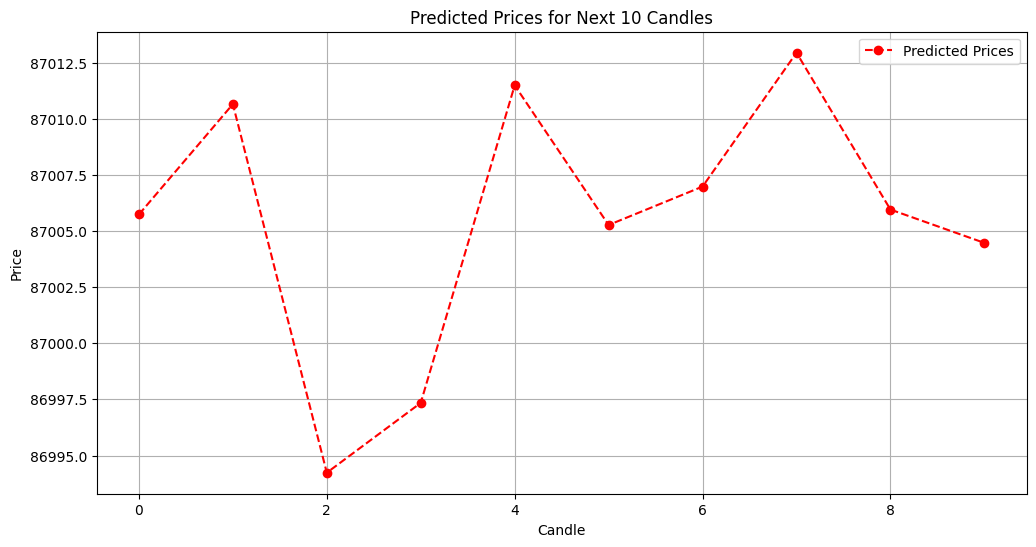

In [39]:
# Predict the next 10 closing prices
next_prices = predict_next_prices(model, df_features, sequence_length, forecast_horizon, scaler, close_scaler)

# Get the last known price for comparison
last_known_price = df['Close'].iloc[-1]

print(f"Last known closing price: ${last_known_price:.2f}")
print("\nPredicted prices for next 10 candles:")
for i, price in enumerate(next_prices):
    change = price - last_known_price
    percent_change = (price / last_known_price - 1) * 100
    print(f"Candle {i+1}: ${price:.2f} (Change: ${change:.2f}, {percent_change:.2f}%)")

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(next_prices, 'o--', label='Predicted Prices', color='red')
plt.title('Predicted Prices for Next 10 Candles')
plt.xlabel('Candle')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout

plt.show()


## 7. Save the Model

In [41]:
# Save the model
model.save('crypto_lstm_model_multi_step.h5')

# Save the scalers
import joblib
joblib.dump(scaler, 'feature_scaler_multi_step.save')
joblib.dump(close_scaler, 'close_scaler_multi_step.save')

print("Model and scalers saved successfully.")

Model and scalers saved successfully.


## 8. Conclusion

In this notebook, we:

1. Loaded cryptocurrency data with technical indicators
2. Modified the time series sequences for multi-step (10 candles) forecasting
3. Built and trained an LSTM model that predicts the next 10 candles
4. Evaluated the model's performance at each step of the forecast
5. Visualized multi-step predictions
6. Made a prediction for the next 10 candles

The model can be further improved by:
- Hyperparameter tuning (especially important for multi-step forecasting)
- Experimenting with teacher forcing or other sequence-to-sequence architectures
- Adding attention mechanisms to improve long-range predictions
- Training separate models for different forecast horizons and combining them